# Comparing datasets over California

Within the state of California we can compare our risk estimates with estimates from two other datasets: (1) the Wildfire Risk to Communities project (as in the other comparison notebook attached to this project) and the [California Fire Hazard Severity Zones](https://osfm.fire.ca.gov/what-we-do/community-wildfire-preparedness-and-mitigation/fire-hazard-severity-zones). This notebook contains those comparisons.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import odc.geo.xr  # noqa
import pandas as pd
import xarray as xr
from odc.geo.xr import xr_reproject
from scipy.stats import kendalltau

warnings.filterwarnings('ignore')

In [2]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
ca = states[states['STUSPS'].isin(['CA'])]
census_tracts = gpd.read_parquet(
    's3://carbonplan-ocr/input/fire-risk/vector/aggregated_regions/tracts/tracts.parquet'
)
ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]

<Axes: >

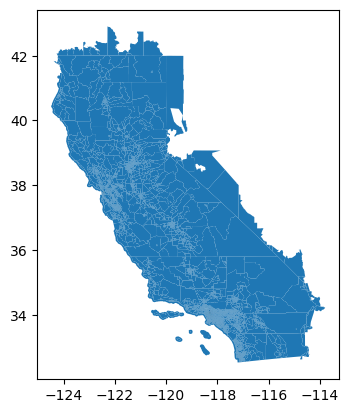

In [3]:
ca_census_tracts.plot()

In [4]:
rebuild_ca_buildings = False
rerun_hazard_extraction = False
version = 'v0.9.0'
if rebuild_ca_buildings:
    building_file = gpd.read_parquet(
        f's3://carbonplan-ocr/output/fire-risk/vector/production/{version}/geoparquet/consolidated-buildings.parquet'
    )
    ca = ca.to_crs(building_file.crs)
    # find all rows
    ca_buildings = building_file.loc[building_file.geometry.intersects(ca.unary_union)]
    ca_buildings.to_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_california_{version}.parquet'
    )

if rerun_hazard_extraction:
    ca_buildings = gpd.read_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_california_{version}.parquet'
    )

    fpath = 's3://carbonplan-ocr/input/fire-risk/tensor/calfire-fhsz/calfire-risk-raster.tif'
    ds = xr.open_dataset(fpath, engine='rasterio')
    ds = ds.odc.assign_crs('epsg:3310')
    ds_reprojected = xr_reproject(ds, how='EPSG:4326')

    # get building coords
    coords = [(geom.x, geom.y) for geom in ca_buildings.geometry.centroid]
    coords = np.array(coords)

    # extract hazard for buildings
    building_hazard = ds_reprojected.sel(
        latitude=xr.DataArray(coords[:, 1], dims='building'),
        longitude=xr.DataArray(coords[:, 0], dims='building'),
        method='nearest',
    )

    # cast all nulls to zeros. areas with zero are considered without hazard in the cal fire approach
    # and by casting them to zero we make them have a lower value than the non-zero values which
    # prepares the data for a ranked test like kendall-tau
    building_hazard = xr.where(building_hazard.band_data.isnull(), 0, building_hazard.band_data)
    ca_buildings['cal-fire-hazard-zone'] = building_hazard.values[0]
    ca_buildings_in_census_tracts = gpd.sjoin(ca_buildings, ca_census_tracts[['GEOID', 'geometry']])
    ca_buildings_in_census_tracts.to_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_tracts_california_{version}.parquet'
    )
else:
    ca_buildings_in_census_tracts = gpd.read_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_tracts_california_{version}.parquet'
    )

## Load in CAL FIRE hazard layer

Note: The CAL FIRE hazard data is very clear that they do not estimate risk, which assesses the level of damage that a fire could cause. The main statistic we use in this analysis is a rank test called the Kendall's Tau which tests for concordance of data, asking: how similarly do two datasets rank areas on a scale from low to high? In other words, given two locations, do the two datsets agree which is higher or lower on a given scale. To do this comparison we assume that it makes sense for the fire hazard scales from CAL FIRE and the fire risk to potential structures scale from our datasets can be compared and that high numbers on either scale come from similar causes. We think this is a reasonable assumption given the similar attributes that each modeling system ingests: high-resolution vegetation maps, dynamic fire model, wind.

In [5]:
def apply_kendall_tau(x, y, variant):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant=variant)
    return pd.Series({f'tau_{variant}': tau, f'p_value_{variant}': p_value})

In [6]:
ca_buildings_in_census_tracts = ca_buildings_in_census_tracts.rename(
    {'GEOID_right': 'GEOID'}, axis=1
)

In [7]:
ds_name_dict = {'CarbonPlan': 'wind_risk_2011', 'Scott (2024)': 'USFS_RPS'}

In [9]:
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']]
for dataset_name, variable_name in ds_name_dict.items():
    new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
        lambda g: apply_kendall_tau(g[variable_name], g['cal-fire-hazard-zone'], 'c')
    )
    new_df.columns = [f'{dataset_name} {column_name}' for column_name in new_df.columns]
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
tract_performance_stats.to_parquet(
    f's3://carbonplan-risks/shapefiles/california_tract_stats_{version}.parquet'
)

In [10]:
variable_name_dict = {
    'tau_c': "Kendall's Tau (c-variant) of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'corr': 'Correlation',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'WRC median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {
    'tau_c': [-1, 1],
    'bias': [-0.1, 0.1],
    'normalized_bias': [-1, 1],
    'corr': [-1, 1],
}

cmaps = {
    'tau_c': 'PRGn',
    'bias': 'RdBu_r',
    'normalized_bias': 'RdBu_r',
    'corr': 'PRGn',
}

When we calculate the concordance of our data with that of CAL FIRE for all census tracts in California, we see that typically the Kendall's Tau is above zero, indicating some concordance. Our dataset has a very small higher level of concordance with the CAL FIRE map than does the Wildfire Risk to Communities dataset.

Text(0.5, 1.0, "Kendall's Tau with respect to Cal-Fire's hazard map")

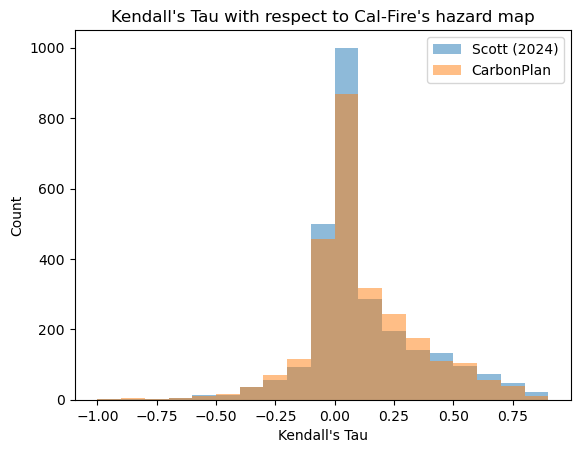

In [11]:
plt.hist(
    tract_performance_stats['Scott (2024) tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='Scott (2024)',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['CarbonPlan tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='CarbonPlan',
    alpha=0.5,
)
plt.legend()
plt.xlabel("Kendall's Tau")
plt.ylabel('Count')
plt.title("Kendall's Tau with respect to Cal-Fire's hazard map")

In [12]:
tract_performance_stats['Scott (2024) tau_c'].mean()

np.float64(0.11573188120979995)

In [13]:
tract_performance_stats['CarbonPlan tau_c'].mean()

np.float64(0.11290196410454119)

Plotting the data across the state we see areas of higher concordance tend to cluster in smaller tracts in more developed areas.

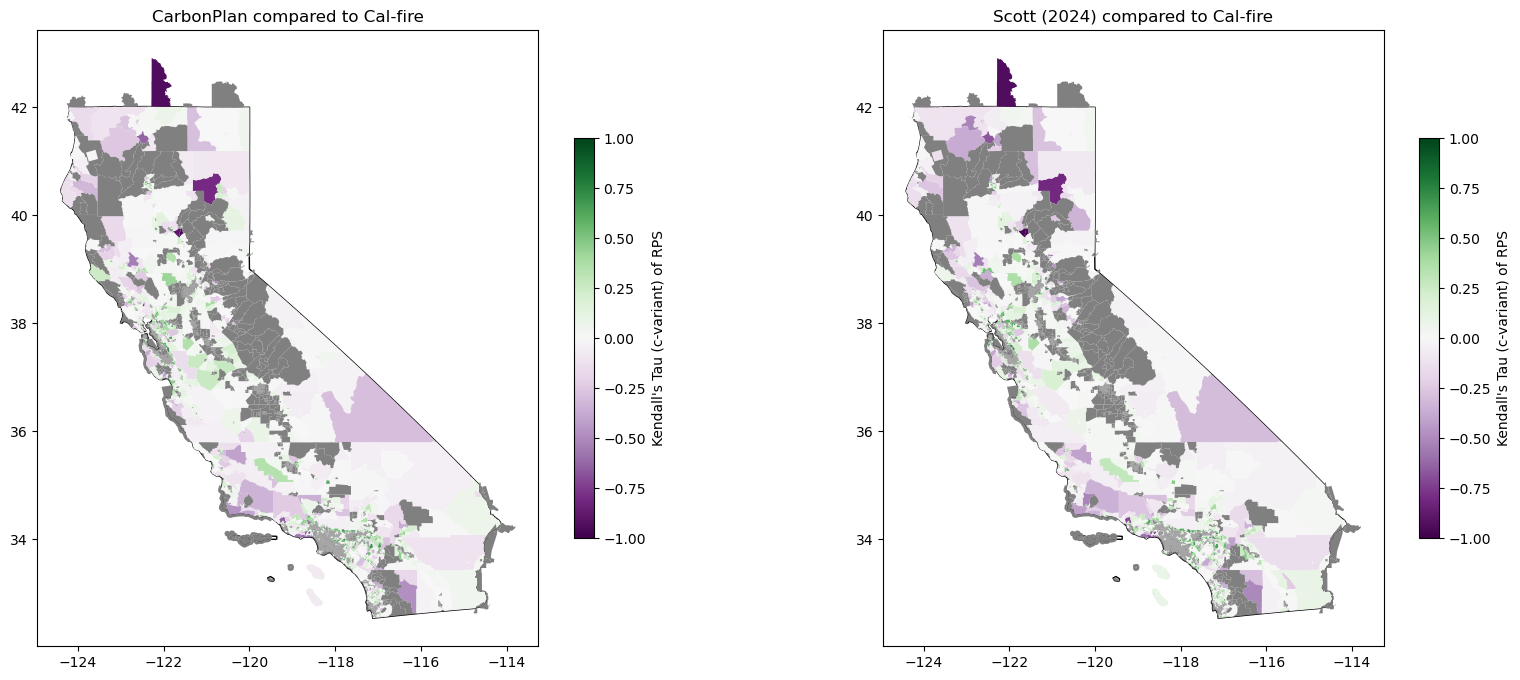

In [14]:
for variable in ['tau_c']:
    fig, axarr = plt.subplots(ncols=2, figsize=(20, 8))
    for i, dataset_name in enumerate(ds_name_dict.keys()):
        ca.plot(ax=axarr[i], color='white', edgecolor='black')
        ax = tract_performance_stats.plot(
            ax=axarr[i],
            column=f'{dataset_name} {variable}',
            vmin=var_lims[variable][0],
            vmax=var_lims[variable][1],
            legend=True,
            cmap=cmaps[variable],
            legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
        )
        tract_performance_stats[
            tract_performance_stats[f'{dataset_name} {variable}'].isnull()
        ].plot(ax=axarr[i], color='grey')
        axarr[i].set_title(f'{dataset_name} compared to Cal-fire')